In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from keras.models import Sequential

from tensorflow.keras.layers import Conv2D ,Dropout, Flatten, Dense, MaxPooling2D, InputLayer
from tensorflow.keras.optimizers import Adam , RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [4]:
data=pd.read_csv('/content/drive/MyDrive/air/data.csv')

In [5]:
df=pd.DataFrame(data)
df

,x-axis,y-axis,z-axis,number
0,1.569064,1.019892,10.355822,0
1,-1.216025,-1.647517,14.082349,0
2,-2.588956,-3.020448,14.239256,0
3,-4.354153,-3.491167,15.063014,0
4,-4.040340,-3.491167,14.278482,0
...,...,...,...,...
1130123,-3.373488,-0.470719,8.159133,9
1130124,-3.451941,-0.392266,8.002226,9
1130125,-3.608847,-0.274586,8.394492,9
1130126,-3.844207,-0.313813,8.472946,9


In [6]:
df['number'].value_counts()

4    119923
3    119888
2    119564
0    119493
1    119103
5    106590
9    106569
8    106549
6    106236
7    106213
Name: number, dtype: int64

In [7]:
x=df[['x-axis','y-axis','z-axis']]
y=df['number']
scaler=StandardScaler()
X=scaler.fit_transform(x)

## Standardized data

In [8]:
scaled_X=pd.DataFrame(data=X,columns=['x-axis','y-axis','z-axis'])
scaled_X['number']=y.values

scaled_X

,x-axis,y-axis,z-axis,number
0,0.981135,0.094412,0.618246,0
1,-0.005268,-0.552226,1.763181,0
2,-0.491523,-0.885054,1.811389,0
3,-1.116709,-0.999166,2.064480,0
4,-1.005565,-0.999166,1.823441,0
...,...,...,...,...
1130123,-0.769383,-0.266945,-0.056664,9
1130124,-0.797169,-0.247926,-0.104872,9
1130125,-0.852741,-0.219398,0.015648,9
1130126,-0.936100,-0.228907,0.039752,9


In [9]:
fs=20
frame_size=fs*10
hop_size=fs*2

In [10]:
def get_frames(df,frame_size,hop_size):
    N_FEATURES=3
    
    frames=[]
    lables=[]
    for i in range(0,len(df)-frame_size,hop_size):
        x=df['x-axis'].values[i: i+frame_size]
        y=df['y-axis'].values[i: i+frame_size]
        z=df['z-axis'].values[i: i+frame_size]   
        
        lable = stats.mode(df['number'][i: i+frame_size])[0][0]
        frames.append([x,y,z])
        lables.append(lable)
    frames=np.asarray(frames).reshape(-1,frame_size,N_FEATURES)
    lables=np.asarray(lables)
    
    return frames ,lables

In [11]:
X_x,Y_y=get_frames(df,frame_size,hop_size)

<ipython-input-10-bba5c3e1c102>:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  lable = stats.mode(df['number'][i: i+frame_size])[0][0]


In [12]:
X_x.shape , Y_y.shape

((28249, 200, 3), (28249,))

In [13]:
X_train , X_test, y_train, y_test = train_test_split(X_x,Y_y,test_size=0.2,random_state=0,stratify=Y_y)

In [14]:
X_test.shape,X_train.shape,y_test.shape,y_train.shape

((5650, 200, 3), (22599, 200, 3), (5650,), (22599,))

In [15]:
X_test= X_test.reshape(5650, 200, 3, 1)
X_train=X_train.reshape(22599, 200, 3, 1)

In [16]:
X_train[0].shape

(200, 3, 1)

### 2D CNN Model

In [17]:
model=Sequential()
model.add(InputLayer(input_shape= X_train[0].shape))
model.add(Conv2D(filters=32, kernel_size=(2, 2), strides=(1, 1), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(2, 2), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding='same'))
model.add(Dropout(0.1))

model.add(Conv2D(filters=64, kernel_size=(2, 2), strides=(1, 1), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(2, 2), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(2, 2), strides=(1, 1), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(2, 2), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=10, activation='softmax'))

In [18]:
early_stopping = EarlyStopping(monitor='val_accuracy', 
    patience=8, 
    min_delta=0.001, 
    mode='max')

In [19]:
model.compile(optimizer=Adam(learning_rate = 0.0005), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], run_eagerly=True)

In [21]:
history = model.fit(X_train, y_train, epochs = 12, batch_size=1, validation_data= (X_test, y_test),verbose=1,callbacks=[early_stopping])

Epoch 1/12
22599/22599 [==============================] - 1779s 79ms/step - loss: 0.1238 - accuracy: 0.9612 - val_loss: 0.0798 - val_accuracy: 0.9722
Epoch 2/12
22599/22599 [==============================] - 1797s 80ms/step - loss: 0.1169 - accuracy: 0.9641 - val_loss: 0.0305 - val_accuracy: 0.9910
Epoch 3/12
22599/22599 [==============================] - 1803s 80ms/step - loss: 0.1096 - accuracy: 0.9674 - val_loss: 0.0272 - val_accuracy: 0.9910
Epoch 4/12
22599/22599 [==============================] - 1821s 81ms/step - loss: 0.1047 - accuracy: 0.9702 - val_loss: 0.0221 - val_accuracy: 0.9933
Epoch 5/12
22599/22599 [==============================] - 1861s 82ms/step - loss: 0.1017 - accuracy: 0.9719 - val_loss: 0.0267 - val_accuracy: 0.9922
Epoch 6/12
22599/22599 [==============================] - 1807s 80ms/step - loss: 0.1045 - accuracy: 0.9710 - val_loss: 0.0357 - val_accuracy: 0.9881
Epoch 7/12
22599/22599 [==============================] - 1844s 82ms/step - loss: 0.1030 - accuracy:

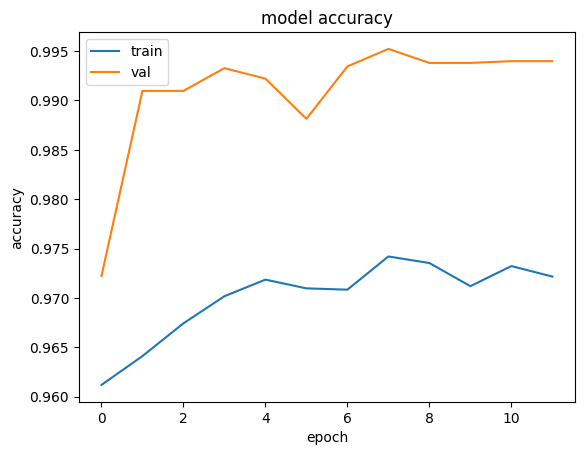

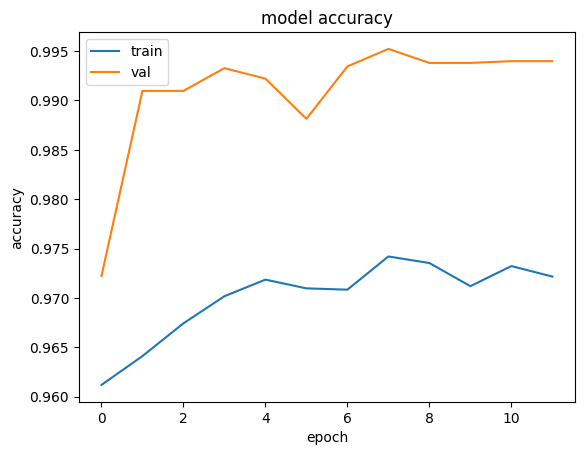

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

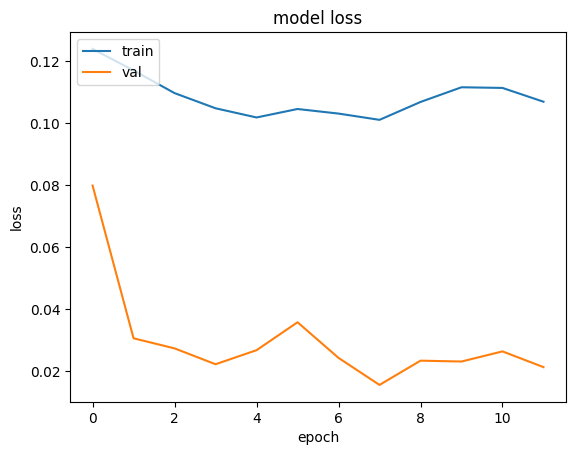

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
p=model.predict(X_test[:1])
a=max((p.max(axis=0)))
print(p)
s=np.where(p==a)#index of the max 
#print(X_test[:1])
print(s)

1/1 [==============================] - 0s 78ms/step
[[2.1051646e-20 3.4343931e-24 4.2387140e-22 7.4350495e-25 1.0000000e+00
  1.2101327e-17 2.7666209e-17 3.8884520e-19 1.1881078e-25 1.9693986e-12]]
(array([0]), array([4]))


In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 3, 32)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 3, 32)        4128      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 2, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 100, 2, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 2, 64)        8256      
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 2, 64)        16448     
                                                        

In [31]:
model.save('/content/drive/MyDrive/air/tuned.h5',save_format='h5')
# !ls /content/drive/MyDrive/air/